
# Лабораторная работа №4

ФИО: Попов Вячеслав Игоревич
Группа: БИВТ-22-СП-5

Что необходимо сделать:

Обучить различные модели глубокого обучения на имеющихся данных

# Считывание данных

In [7]:
from torch.utils.data import Dataset
import torch
import kagglehub
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


class AdaptivityLevel(Dataset): # Создадим класс датасета
  def __init__(self, X: pd.DataFrame, y: pd.DataFrame):
    self.X = torch.from_numpy(X.values).float()  # Преобразование фичей в тензор
    self.y = torch.from_numpy(y.values).long()  # Преобразование меток в тензор

  def __len__(self):
    return self.X.shape[0]  # Возвращает количество записей

  def __getitem__(self, index):
    return (self.X[index], self.y[index])  # Возвращает одну запись (фичи и метку)

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

class BaseNet(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_layers):
        super(BaseNet, self).__init__()
        layers = []

        if hidden_layers:
            prev_dim = input_dim
            for neurons in hidden_layers:
                layers.append(nn.Linear(prev_dim, neurons))  # Полносвязный слой
                layers.append(nn.ReLU())  # Активация ReLU
                prev_dim = neurons
            layers.append(nn.Linear(prev_dim, output_dim))  # Последний слой
        else:
            layers.append(nn.Linear(input_dim, output_dim))  # Только выходной слой

        layers.append(nn.Softmax(dim=1))  # Софтмакс для вероятностей классов
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)  # Прямое распространение через сеть

class NoHiddenLayersNet(BaseNet):
  def __init__(self, input_dim, output_dim):
      super(NoHiddenLayersNet, self).__init__(
          input_dim,
          output_dim,
          hidden_layers=[]
      )


class OneHiddenLayerNet(BaseNet):
  def __init__(self, input_dim, output_dim):
      super(OneHiddenLayerNet, self).__init__(
          input_dim,
          output_dim,
          hidden_layers=[64]
      )

class ManyLayersNet(BaseNet):
  def __init__(self, input_dim, output_dim):
      super(ManyLayersNet, self).__init__(
          input_dim,
          output_dim,
          hidden_layers=[128, 64, 32, 16]
      )

In [16]:
from sklearn.model_selection import train_test_split
def preprocess(ds):
  for item in ds.keys():
    le = LabelEncoder()
    le.fit(ds[item])
    ds[item] = le.transform(ds[item])
  ds
  x = ds.drop('Adaptivity Level', axis=1)
  y = ds['Adaptivity Level']

  return train_test_split(
    x, y, test_size=0.25, random_state=42)
  ds

In [17]:
from torch.utils.data import DataLoader
path = 'students_adaptability_level_online_education.csv'
pd_ds = pd.read_csv(path)

X_train, X_test, y_train, y_test = preprocess(pd_ds)


test_ds = AdaptivityLevel(X_test, y_test)
train_ds = AdaptivityLevel(X_train, y_train)

train_dataloader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size=64, shuffle=True)

input_dim = X_test.shape[1] # кол-во фичей
output_dim = 3 # кол-во классов

In [18]:
def train_model(model, optimizer, train_loader, test_loader, epochs=100):
    criterion = nn.CrossEntropyLoss()
    train_loss_history = []
    test_loss_history = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_loss_history.append(train_loss)

        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                test_loss += loss.item()

        test_loss /= len(test_loader)
        test_loss_history.append(test_loss)

        # Вывод метрик на текущей эпохе
        print(f"Epoch {epoch + 1}/{epochs}: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    return train_loss_history, test_loss_history

Epoch 1/100: Train Loss: 1.1214, Test Loss: 1.1090
Epoch 2/100: Train Loss: 1.1112, Test Loss: 1.1000
Epoch 3/100: Train Loss: 1.0956, Test Loss: 1.0920
Epoch 4/100: Train Loss: 1.0844, Test Loss: 1.0837
Epoch 5/100: Train Loss: 1.0754, Test Loss: 1.0773
Epoch 6/100: Train Loss: 1.0748, Test Loss: 1.0734
Epoch 7/100: Train Loss: 1.0651, Test Loss: 1.0675
Epoch 8/100: Train Loss: 1.0588, Test Loss: 1.0612
Epoch 9/100: Train Loss: 1.0474, Test Loss: 1.0576
Epoch 10/100: Train Loss: 1.0399, Test Loss: 1.0546
Epoch 11/100: Train Loss: 1.0404, Test Loss: 1.0501
Epoch 12/100: Train Loss: 1.0292, Test Loss: 1.0469
Epoch 13/100: Train Loss: 1.0294, Test Loss: 1.0453
Epoch 14/100: Train Loss: 1.0200, Test Loss: 1.0431
Epoch 15/100: Train Loss: 1.0238, Test Loss: 1.0435
Epoch 16/100: Train Loss: 1.0225, Test Loss: 1.0388
Epoch 17/100: Train Loss: 1.0145, Test Loss: 1.0361
Epoch 18/100: Train Loss: 1.0119, Test Loss: 1.0342
Epoch 19/100: Train Loss: 1.0084, Test Loss: 1.0334
Epoch 20/100: Train L

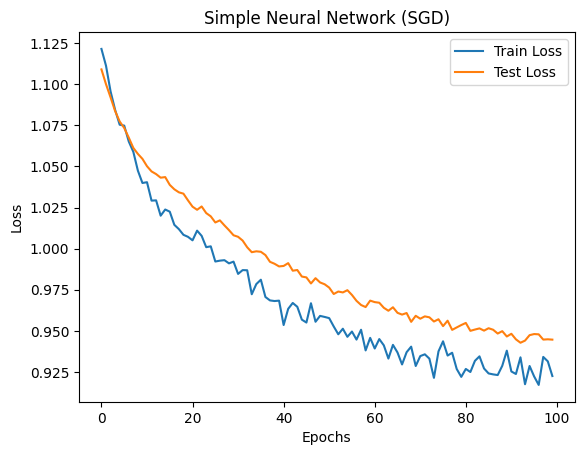

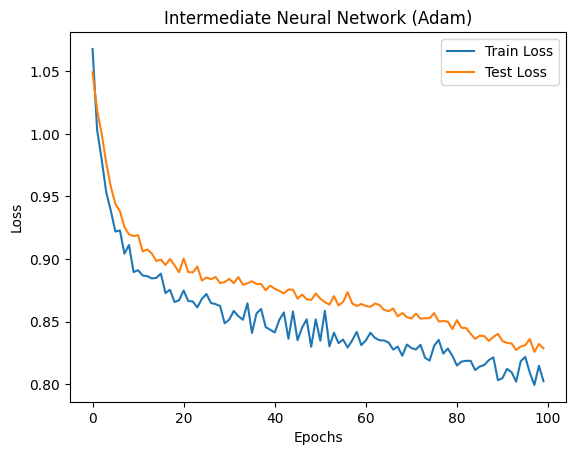

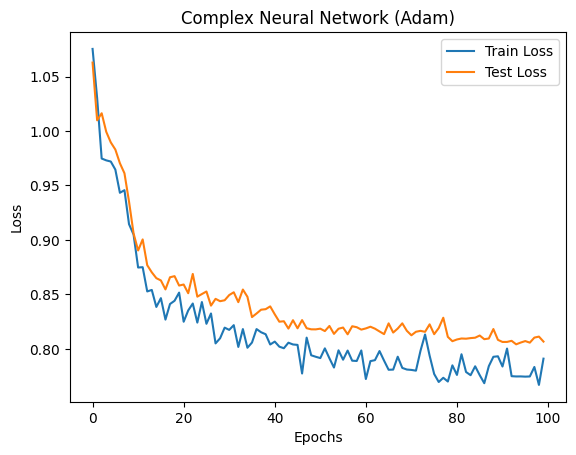

In [19]:
input_dim, output_dim = X_train.shape[1], len(set(y_train))

zero_model = NoHiddenLayersNet(input_dim, output_dim)
zero_optimizer = optim.SGD(zero_model.parameters(), lr=0.01)
zero_train_loss, zero_test_loss = train_model(zero_model, zero_optimizer, train_dataloader, test_dataloader)

one_model = OneHiddenLayerNet(input_dim, output_dim)
one_optimizer = optim.Adam(one_model.parameters(), lr=0.001)
one_train_loss, one_test_loss = train_model(one_model, one_optimizer, train_dataloader, test_dataloader)

many_model = ManyLayersNet(input_dim, output_dim)
many_optimizer = optim.Adam(many_model.parameters(), lr=0.001)
many_train_loss, many_test_loss = train_model(many_model, many_optimizer, train_dataloader, test_dataloader)



def plot_learning_curves(train_loss, test_loss, title):
    plt.plot(train_loss, label='Train Loss')
    plt.plot(test_loss, label='Test Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_learning_curves(zero_train_loss, zero_test_loss, "Simple Neural Network (SGD)")
plot_learning_curves(one_train_loss, one_test_loss, "Intermediate Neural Network (Adam)")
plot_learning_curves(many_train_loss, many_test_loss, "Complex Neural Network (Adam)")

In [20]:
import torch

def calculate_accuracy(model, data_loader):
    model.eval()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            outputs = model(X_batch)

            _, predicted = torch.max(outputs, 1)

            # Считаем количество правильных предсказаний
            correct_predictions += (predicted == y_batch).sum().item()
            total_predictions += y_batch.size(0)

    accuracy = correct_predictions / total_predictions
    return accuracy

models = [zero_model, one_model, many_model]

for model in models:
  train_accuracy = calculate_accuracy(model, train_dataloader)
  test_accuracy = calculate_accuracy(model, test_dataloader)

  print(f"Train Accuracy for {type(model)}: {train_accuracy * 100:.2f}%")
  print(f"Test Accuracy for {type(model)}: {test_accuracy * 100:.2f}%")

Train Accuracy for <class '__main__.NoHiddenLayersNet'>: 64.23%
Test Accuracy for <class '__main__.NoHiddenLayersNet'>: 60.60%
Train Accuracy for <class '__main__.OneHiddenLayerNet'>: 75.08%
Test Accuracy for <class '__main__.OneHiddenLayerNet'>: 72.52%
Train Accuracy for <class '__main__.ManyLayersNet'>: 77.08%
Test Accuracy for <class '__main__.ManyLayersNet'>: 74.50%
